<a href="https://colab.research.google.com/github/weedge/doraemon-nb/blob/main/Chainer_MNIST_CPU_GPU_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dataset: https://www.kaggle.com/datasets/hojjatk/mnist-dataset


In [ ]:
# Install Chainer and CuPy!

#!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
#!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
#!pip install https://github.com/kmaehashi/chainer-colab/releases/download/2018-02-06/cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl
#!pip install 'chainer==4.0.0b3'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
ERROR: cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.9/366.9 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chainer: filename=chainer-4.0.0b3-py3-none-any.whl size=548991 sha256=b07f2c4201918224ffedd8d4700b5fe5aac571007e5f164f31cd9378f9db1c8a
  Stored in directory: /root/.cache/pip/wheels/9c/22/64/1cdd853522f1b72211f04ed523768845c0ad76047d95604c78
Successfully built chainer


In [1]:
#!curl https://colab.chainer.org/install | sh -
!pip install chainer



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967716 sha256=8ecf59d796de89326f452c43e55d28d6e6cf51d8e4b55fd30c0966742710ecb3
  Stored in directory: /root/.cache/pip/wheels/c4/95/6a/16014db6f761c4e742755b64aac60dbe142da1df6c5919f790
Successfully built chainer


In [2]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.datasets import mnist

In [3]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


In [4]:
train, test = mnist.get_mnist()

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

In [8]:
class MLP(Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(None, n_mid_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

model = MLP()

In [9]:
max_epoch = 10

model = L.Classifier(model)

gpu_id = 0  # Set to -1 if you use CPU
if gpu_id >= 0:
    model.to_gpu(gpu_id)  # If you use CPU, comment out this line

# selection of your optimizing method
optimizer = optimizers.MomentumSGD()

# Give the optimizer a reference to the model
optimizer.setup(model)

# Get an updater that uses the Iterator and Optimizer
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

# Setup a Trainer
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')

In [10]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

In [11]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.543279    0.851096       0.264448              0.923457                  23.0749       
2           0.232655    0.932403       0.189789              0.945016                  26.7914       
3           0.1727      0.95066        0.153196              0.953817                  29.5898       
4           0.140844    0.958534       0.128832              0.962322                  32.3994       
5           0.117408    0.965935       0.11614               0.965487                  35.1954       
6           0.100664    0.970649       0.104894              0.968651                  39.0091       
7           0.0886882   0.97468        0.0992202             0.96964                   41.8564       
8           0.0790047   0.977013       0.0918179             0.971222                  44.9361       
9           0.0687488   0.980111       0.0825738             0.973892               

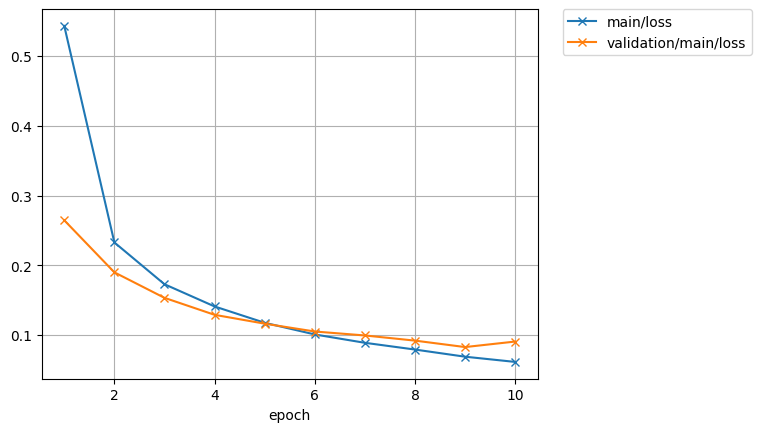

In [12]:
from IPython.display import Image
Image('mnist_result/loss.png')

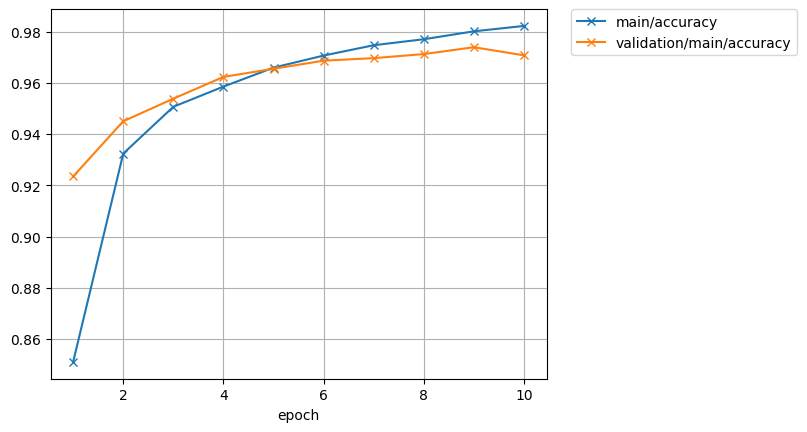

In [13]:
Image('mnist_result/accuracy.png')